# ERA5 tutorial

ERA5 contains historical weather data, which can be used to analyse very wide range of problems. In this tutorial we briefly demonstrate how to:
1. Get timerange data for single location and single variable
2. Analyse possible wind farm production potential for three different locations

To read more about the ERA5 dataset, please follow these links:
1. https://data.planetos.com/datasets/ecmwf_era5
2. https://software.ecmwf.int/wiki/display/CKB

To learn more about Planet OS/Intertrust datahub, please refer to documentation in https://data.planetos.com/datasets

In [128]:
# Initialize notebook environment.
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Import Planet OS API
from API_client.python.datahub import datahub_main
from API_client.python.lib.dataset import dataset
from API_client.python import package_api

Initialize dataset, print available variable names. In order to be able to access the data, save your API key in the file `APIKEY` and put it into the same folder where you run this notebook.

In [129]:
apikey = open('APIKEY').readlines()[0].strip()
dh = datahub_main(apikey)
ds = dataset('ecmwf_era5',dh,debug=True)

In [4]:
ds.variable_names()

['100_metre_U_wind_component_surface',
 '100_metre_V_wind_component_surface',
 '10_metre_U_wind_component_surface',
 '10_metre_V_wind_component_surface',
 '2_metre_dewpoint_temperature_surface',
 '2_metre_temperature_surface',
 'Maximum_temperature_at_2_metres_surface_1hour_Maximum',
 'Mean_sea_level_pressure_surface',
 'Minimum_temperature_at_2_metres_surface_1hour_Minimum',
 'Snow_density_surface',
 'Snow_depth_surface',
 'Surface_pressure_surface',
 'Surface_solar_radiation_downwards_surface_1hour_Accumulation',
 'Total_precipitation_surface_1hour_Accumulation',
 'lat',
 'lon',
 'time0',
 'time1']

In [5]:
# Choose location, variable
lon = 26
lat = 58
variable = '2_metre_temperature_surface'

In [22]:
d1 = ds.get_json_data_in_pandas(count=100000,**{'vars':'2_metre_temperature_surface','lon':lon,'lat':lat})

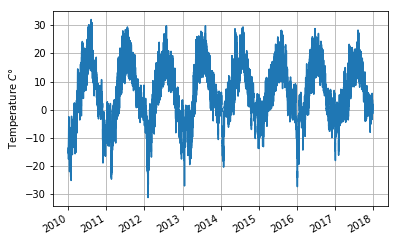

In [132]:
fig=plt.figure()
plt.plot(d1['time'],d1['2_metre_temperature_surface']-273.15)
plt.ylabel('Temperature $C \degree$')
plt.grid()
fig.autofmt_xdate()
plt.show()

## Wind energy example

As a more advanced use case, let's try to analyse potential wind energy production in three different locations. 
For this, we take wind speed at 100 m height, apply a simplified energy production curve to hourly data, and get a statistics for hourly and weekly average (wa) data.

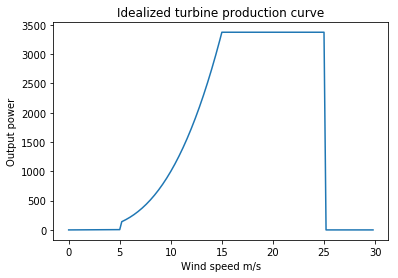

In [133]:
def production_curve(wind_speed):
    """ Production curve of a turbine/farm can be simplified as a 
    cube of wind speed, with production 
         starting from a particular wind speed        'v_cut_in'
         getting maximum output power at wind speed   'v_rated'
         production halted at very strong wind speeds 'v_cut_off'
    Note that this simplified approach is useful for comparing places only.
    """
    v_cut_in = 5
    v_rated = 15
    v_cut_off = 25
    max_production = 15**3
    rt = np.zeros_like(wind_speed)
    rt = np.where(wind_speed>v_cut_in, wind_speed**3,wind_speed)
    rt = np.where(wind_speed>v_rated,max_production,rt)
    rt = np.where(wind_speed>v_cut_off,0,rt)
    return rt
    
def wind_production_smooth(wspd):
    """Weekly average production as a moving average"""
    def moving_average(a, n=3) :
        ret = np.cumsum(a, dtype=float)
        ret[n:] = ret[n:] - ret[:-n]
        return ret[n - 1:] / n
    return moving_average(np.array(wspd), n=7*24)

def station_statistics(lonlats, count = 100):
    """
    Compute min, max, mean, 5'th and 95'th percentiles for both 
    hourly values and weekly averages
    """
    ddwd = [(name,ds.get_json_data_in_pandas(count=count, 
                **{'vars':'100_metre_U_wind_component_surface,100_metre_V_wind_component_surface',
                'lon':lon,
                'lat':lat})) for name,lon,lat in lonlats]
    wspds = [(name,np.sqrt(dd['100_metre_U_wind_component_surface']**2 + dd['100_metre_V_wind_component_surface']**2))
              for name,dd in ddwd]
    pcurves = [(name,production_curve(dd)) for name, dd in wspds]
    weekly_ave = [wind_production_smooth(dd) for name,dd in pcurves]    
    retdic = {}
    for dd, wa in zip(pcurves,weekly_ave):
        retdic[dd[0]] = (np.amin(dd[1]),np.amax(dd[1]),np.mean(dd[1]),np.percentile(dd[1],5),np.percentile(dd[1],95),
                         np.amin(wa), np.amax(wa), np.mean(wa), np.percentile(wa,5), np.percentile(wa,95),
                        np.sum(dd[1]))                    
        
    return pd.DataFrame(retdic, index=['min','max','mean','5 percentile', '95 percentile',
                                       'wa min','wa max','wa mean','wa 5 percentile', 'wa 95 percentile', 'sum'])

## Power curve demo
x = np.arange(0,30, 0.2)
fig = plt.figure()
plt.plot(x,production_curve(x))
plt.xlabel('Wind speed m/s')
plt.ylabel('Output power')
plt.title("Idealized turbine production curve")
plt.show()

In [134]:
stations = [('Hiiumaa',22.1, 59),            ## planned off-shore wind farm in North-West Estonia
            ('Tõravere',26+28/60, 58+16/60), ## Inland climate station in South-East Estonia
            ('GYM',-3 -35/60, 53+27/60)]     ## existing off-shore wind farm west to Scotland
abc = station_statistics(stations,count=10000)

In [135]:
abc.transpose()

,min,max,mean,5 percentile,95 percentile,wa min,wa max,wa mean,wa 5 percentile,wa 95 percentile,sum
GYM,0.000000,3375.0,781.445151,2.359436,3375.000000,61.956120,2398.221162,780.378387,202.650405,1737.967417,7.814452e+06
Hiiumaa,0.050631,3375.0,770.282982,2.309145,2944.666319,71.048125,2062.972979,777.684667,231.585537,1564.945427,7.702830e+06
Tõravere,0.117344,3375.0,403.100573,1.921589,1532.588197,22.684435,1380.830043,405.582212,65.306773,835.503148,4.031006e+06
